In [ ]:
#Import modules
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras import optimizers
from keras import models
from keras import layers

In [ ]:
#Specify path for training, validation and testing data
train_dir = '/content/drive/MyDrive/CRACK + GROOVE -Train-Val-Split-80-20/train'
test_dir = '/content/drive/MyDrive/CRACK + GROOVE -Train-Val-Split-80-20/Test'
validation_dir = '/content/drive/MyDrive/CRACK + GROOVE -Train-Val-Split-80-20/val'

## Preprocess and augment images

In [ ]:
train_datagenerator = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

#Instantiate testing ImageDataGenerator object
#rescale to ensure that all pixel values are in range [0-1]
#no further data augmentation
test_datagenerator = ImageDataGenerator(rescale=1./255)

#Define function to generate augmented training dataset from training data directory
def train_prep(data_location, target_image_size):
    training_generator = train_datagenerator.flow_from_directory(
        data_location,
        target_size = target_image_size,
        batch_size = 64,
        class_mode = 'binary')
    return training_generator

#Define function to generate validation/testing dataset from data directory
def val_test_prep(data_location, target_image_size):
    val_test_generator = test_datagenerator.flow_from_directory(
        data_location,
        target_size = target_image_size,
        batch_size = 64,
        class_mode = 'binary')
    return val_test_generator

#Generate training data
train_generator = train_prep(train_dir, (150, 150))

#Generate validation data
validation_generator = val_test_prep(validation_dir, (150, 150))

Found 3240 images belonging to 2 classes.
Found 810 images belonging to 2 classes.


## Instantiate pre-trained VGG16 convolutional base

In [ ]:
convolutional_base = VGG16(weights = 'imagenet', include_top = False)

58889256/58889256 [==============================] - 5s 0us/step


In [ ]:
#Create sequential model
my_model = models.Sequential()
#Add convolutional base
my_model.add(convolutional_base)
#Add Global Average Pooling layer to downscale parameter space
my_model.add(layers.GlobalAveragePooling2D())
#Add dense layers to learn classes and output binary predictions
my_model.add(layers.Dense(256, activation = 'relu'))
my_model.add(layers.Dense(1, activation = 'sigmoid'))

#Display summary of model architecture
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


## Freeze convolutional base

In [ ]:
convolutional_base.trainable = False

## Compile Model


In [ ]:
my_model.compile(loss = 'binary_crossentropy',
                 optimizer = optimizers.RMSprop(learning_rate = 2e-5),
                 metrics = ['acc'])

In [ ]:
batch_size = 64

## Train the densely connected layers on training dataset

In [ ]:
history_dense_top = my_model.fit(
      train_generator,
      steps_per_epoch=int(3240/batch_size),
      epochs=30,
      validation_data=validation_generator,
      validation_steps=int(810/batch_size))

Epoch 1/30
50/50 [==============================] - 2361s 47s/step - loss: 0.7069 - acc: 0.5091 - val_loss: 0.6699 - val_acc: 0.5781
Epoch 2/30
50/50 [==============================] - 136s 3s/step - loss: 0.6625 - acc: 0.6559 - val_loss: 0.6404 - val_acc: 0.7956
Epoch 3/30
50/50 [==============================] - 135s 3s/step - loss: 0.6383 - acc: 0.7572 - val_loss: 0.6155 - val_acc: 0.8490
Epoch 4/30
50/50 [==============================] - 136s 3s/step - loss: 0.6178 - acc: 0.7894 - val_loss: 0.5932 - val_acc: 0.8646
Epoch 5/30
50/50 [==============================] - 137s 3s/step - loss: 0.5935 - acc: 0.8149 - val_loss: 0.5719 - val_acc: 0.8672
Epoch 6/30
50/50 [==============================] - 136s 3s/step - loss: 0.5756 - acc: 0.8202 - val_loss: 0.5520 - val_acc: 0.8542
Epoch 7/30
50/50 [==============================] - 136s 3s/step - loss: 0.5600 - acc: 0.8265 - val_loss: 0.5305 - val_acc: 0.8737
Epoch 8/30
50/50 [==============================] - 137s 3s/step - loss: 0.5389 -

In [ ]:
#Evaluate model before fine tuning
test_generator = test_datagenerator.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')
test_loss_, test_acc_ = my_model.evaluate(test_generator, steps=37)
print('test acc:', test_acc_)

Found 450 images belonging to 2 classes.
 8/37 [=====>........................] - ETA: 13:37 - loss: 0.3562 - acc: 0.8644

37/37 [==============================] - 199s 5s/step - loss: 0.3562 - acc: 0.8644
test acc: 0.8644444346427917


## Unfreeze final 3 layers of convolutional base

In [ ]:
#Display structure of convolutional base
convolutional_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
#Unfreeze all convolutional layers in block5
convolutional_base.trainable = True

for layer in convolutional_base.layers:
    if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
#Compile model
my_model.compile(loss = 'binary_crossentropy',
                 optimizer = optimizers.RMSprop(learning_rate = 1e-5),
                 metrics = ['acc'])

## Finetune model

In [ ]:
history_final = my_model.fit(
              train_generator,
              steps_per_epoch=int(3240/batch_size),
              epochs=100,
              validation_data=validation_generator,
              validation_steps=int(810/batch_size))

Epoch 1/100
50/50 [==============================] - 141s 3s/step - loss: 0.2989 - acc: 0.8791 - val_loss: 0.2161 - val_acc: 0.9036
Epoch 2/100
50/50 [==============================] - 138s 3s/step - loss: 0.2340 - acc: 0.9144 - val_loss: 0.2100 - val_acc: 0.9115
Epoch 3/100
50/50 [==============================] - 139s 3s/step - loss: 0.2094 - acc: 0.9219 - val_loss: 0.1688 - val_acc: 0.9271
Epoch 4/100
50/50 [==============================] - 137s 3s/step - loss: 0.1998 - acc: 0.9279 - val_loss: 0.1681 - val_acc: 0.9297
Epoch 5/100
50/50 [==============================] - 138s 3s/step - loss: 0.1834 - acc: 0.9336 - val_loss: 0.1638 - val_acc: 0.9349
Epoch 6/100
50/50 [==============================] - 136s 3s/step - loss: 0.1746 - acc: 0.9370 - val_loss: 0.1909 - val_acc: 0.9258
Epoch 7/100
50/50 [==============================] - 137s 3s/step - loss: 0.1708 - acc: 0.9421 - val_loss: 0.1477 - val_acc: 0.9388
Epoch 8/100
50/50 [==============================] - 136s 3s/step - loss: 0.

## Plotting the Model Results

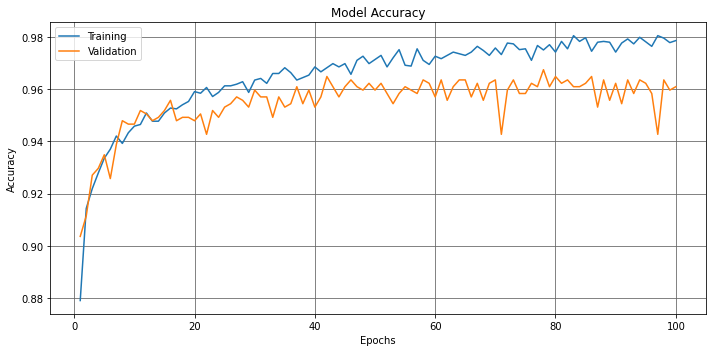

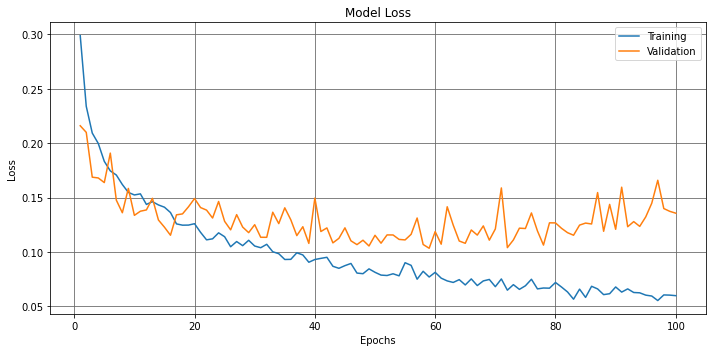

In [ ]:
import matplotlib.pyplot as plt
acc = history_final.history['acc']
val_acc = history_final.history['val_acc']
loss = history_final.history['loss']
val_loss = history_final.history['val_loss']

epochs_range = range(1, len(history_final.epoch) + 1)


plt.figure(figsize=(10,5))

plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))

plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

## Evaluate performance of fine-tuned model on testing dataset

In [ ]:
test_generator = test_datagenerator.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
test_loss, test_acc = my_model.evaluate(test_generator, steps=37)
print('test acc:', test_acc)

Found 450 images belonging to 2 classes.
23/37 [=================>............] - ETA: 9s - loss: 0.1185 - acc: 0.9667

37/37 [==============================] - 17s 421ms/step - loss: 0.1185 - acc: 0.9667
test acc: 0.9666666388511658


## Save the Model 

In [ ]:
my_model.save("/content/drive/MyDrive/model_VGG16_transfer_Crack-Groove_100.h5")

## Testing on a Single Image

1/1 [==============================] - 9s 9s/step


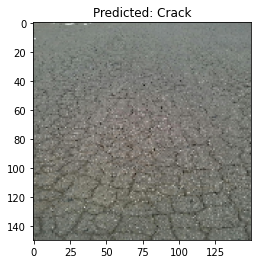

In [ ]:
from keras.models import load_model
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
import numpy as np
import matplotlib.pyplot as plt
import os 
from keras.models import load_model
  
model = load_model('/content/drive/MyDrive/model_VGG16_transfer_Crack-Groove_100.h5')
  
image = load_img('/content/drive/MyDrive/Test-Combined/Crack_1024.jpg', target_size=(150, 150))
img = np.array(image)
img = img / 255.0
img = img.reshape(1,150,150,3)
label = model.predict(img)
if label < 0.5:
    plt.title ("Predicted: Crack")
else:
    plt.title("Predicted: Groove")
   
plt.imshow(image)

## Prediction on Test Images- Crack+Groove -Test Folder Images 

In [ ]:
# !pip install colorama

In [1]:
from keras.models import load_model
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
import numpy as np
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style
import os

y_true = []
y_pred = []  
model = load_model('/content/drive/MyDrive/model_VGG16_transfer_Crack-Groove_100.h5')
fig, ax = plt.subplots()  
for img in os.listdir('/content/drive/MyDrive/Test-Combined/'):
    img_class_name = img.split('_')[0]
    if img_class_name == 'Crack':
        y_true.append('Crack') 
    else:
        y_true.append('Groove')
    print(f"-------------------------------------------------------------------")
    print(Fore.RED + "Actual:", img_class_name)
    image = load_img('/content/drive/MyDrive/Test-Combined/'+img, target_size=(150, 150))
    orig_img = image
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1,150,150,3)
    label = model.predict(img)
    if label < 0.5:
      plt.title ("Predicted: Crack")
      y_pred.append('Crack')
    else:
      plt.title("Predicted: Groove")
      y_pred.append('Groove')

    plt.imshow(image)
    plt.show()

## Confusion Matrix

[[220   5]
 [ 10 215]]


[Text(0, 0.5, 'Crack'), Text(0, 1.5, 'Groove')]

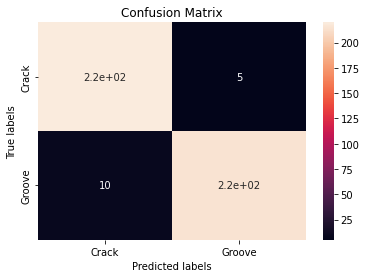

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
cfm = confusion_matrix(y_true, y_pred)
print(cfm)
ax= plt.subplot()
sns.heatmap(cfm, annot=True, ax = ax);
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Crack', 'Groove'])
ax.yaxis.set_ticklabels(['Crack', 'Groove'])

## Classification Report

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       Crack       0.96      0.98      0.97       225
      Groove       0.98      0.96      0.97       225

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450

